# 주제: 게시판 질문 데이터 분석을 통한 유저 동향 및 주요 질문 키워드 파악

In [432]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import time
import requests
from urllib.request import urlopen
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from eunjeon import Mecab
from wordcloud import WordCloud
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1. 던파 공식사이트 게시판 질문 데이터 크롤링

In [108]:
url = 'https://df.nexon.com/df/community/dnfboard'
driver = webdriver.Chrome(executable_path = 'chromedriver')
driver.get(url)
html = driver.page_source
soup = bs(html, 'html.parser')
table = soup.find("div", {"class":"category_dl"})
characters = table.find_all("dd")
address_list = []
for address in characters:
    address_list.append(address.select_one('a').get('href'))
address_list #전직 캐릭터별 url 끝주소

['?mode=list&job=0&grow_type=1',
 '?mode=list&job=0&grow_type=2',
 '?mode=list&job=0&grow_type=3',
 '?mode=list&job=0&grow_type=4',
 '?mode=list&job=0&grow_type=5',
 '?mode=list&job=11&grow_type=1',
 '?mode=list&job=11&grow_type=3',
 '?mode=list&job=11&grow_type=4',
 '?mode=list&job=11&grow_type=2',
 '?mode=list&job=11&grow_type=5',
 '?mode=list&job=7&grow_type=1',
 '?mode=list&job=7&grow_type=2',
 '?mode=list&job=7&grow_type=3',
 '?mode=list&job=7&grow_type=4',
 '?mode=list&job=1&grow_type=1',
 '?mode=list&job=1&grow_type=2',
 '?mode=list&job=1&grow_type=3',
 '?mode=list&job=1&grow_type=4',
 '?mode=list&job=2&grow_type=1',
 '?mode=list&job=2&grow_type=2',
 '?mode=list&job=2&grow_type=3',
 '?mode=list&job=2&grow_type=4',
 '?mode=list&job=2&grow_type=5',
 '?mode=list&job=5&grow_type=1',
 '?mode=list&job=5&grow_type=2',
 '?mode=list&job=5&grow_type=3',
 '?mode=list&job=5&grow_type=4',
 '?mode=list&job=8&grow_type=1',
 '?mode=list&job=8&grow_type=2',
 '?mode=list&job=8&grow_type=3',
 '?mo

In [109]:
len(address_list) #63개의 캐릭터(전직) + 공통 게시판 url 주소 끝자리

64

In [ ]:
for order in range(len(address_list)-1): #공통 질문 제외
    url = 'https://df.nexon.com/df/community/dnfboard'+address_list[order]
    driver = webdriver.Chrome(executable_path = 'chromedriver')
    driver.get(url)
    html = driver.page_source
    soup = bs(html, 'html.parser')
    questions = '#title_type_form > p:nth-child(6) > label'
    select = driver.find_element_by_css_selector(questions)
    select.click()
    time.sleep(2)
    
    last_page = '#container > div.contnet > div.dfboard_lst > div.paging > a:nth-child(14) > img'
    select2 = driver.find_element_by_css_selector(last_page)
    select2.click()
    html = driver.page_source
    soup = bs(html, 'html.parser')
    total_pages = int(soup.find("strong", {"class":"end"}).text)
    time.sleep(2)
    
    first_page = '#container > div.contnet > div.dfboard_lst > div.paging > a:nth-child(1) > img'
    select3 = driver.find_element_by_css_selector(first_page)
    select3.click()
 
    excel_file = openpyxl.Workbook()
    excel_sheet = excel_file.active
    excel_sheet.column_dimensions['B'].width = 100
    num = 0
    excel_sheet.append(['No', 'Title', 'date', 'views'])


    for page in range(total_pages):
        driver.implicitly_wait(3)
        html = driver.page_source
        soup = bs(html, 'html.parser')
        table = soup.find("table", {"class":"tbl"})
        table_rows = table.find_all("tr")

        for row in table_rows[7:]:
            line = row.find_all('td')
            title = line[0].text
            date = line[-3].text
            views = line[-2].text
            num+= 1
            excel_sheet.append([num, title, date, views])
            excel_file.save('bulitin_board_questions'+str(order)+'.xlsx')
            excel_file.close()
        
        try:
            next_page = '#container > div.contnet > div.dfboard_lst > div.paging > a:nth-child(13) > img'
            select4 = driver.find_element_by_css_selector(next_page)
            select4.click()
            time.sleep(3)
            driver.implicitly_wait(3)
        except:
            pass            

    time.sleep(2)
    driver.close()

# 2. 전처리

### 연도 추가 + 중복 제거 + 데이터 통합

In [348]:
character_list = ['남귀검사_웨펀마스터', '남귀검사_소울브링어', '남귀검사_버서커', '남귀검사_아수라', '남귀검사_검귀', 
             '여귀검사_소드마스터', '여귀검사_데몬슬레이어', '여귀검사_베가본드', '여귀검사_다크템플러', '여귀검사_블레이드',
             '남격투가_남넨마스터', '남격투가_남스트라이커', '남격투가_남스트리트파이터', '남격투가_남그래플러',
             '여격투가_여넨마스터', '여격투가_여스트라이커', '여격투가_여스트리트파이터', '여격투가_여그래플러',
             '남거너_남레인저', '남거너_남런처', '남거너_남메카닉', '남거너_남스핏파이어', '남거너_어썰트',
             '여거너_여레인저', '여거너_여런처', '여거너_여메카닉', '여거너_여스핏파이어',
             '남마법사_엘레멘탈바머', '남마법사_빙결사', '남마법사_블러드메이지', '남마법사_스위프트마스터', '남마법사_디멘션워커',
             '여마법사_엘레멘탈마스터', '여마법사_소환사', '여마법사_배틀메이지', '여마법사_마도학자', '여마법사_인챈트리스',
             '남프리스트_남크루세이더', '남프리스트_인파이터', '남프리스트_퇴마사', '남프리스트_어벤저',
             '여프리스트_여크루세이더', '여프리스트_이단심판관', '여프리스트_무녀', '여프리스트_미스트리스',
             '도적_로그', '도적_사령술사', '도적_쿠노이치', '도적_섀도우댄서',
             '나이트_엘븐나이트', '나이트_카오스', '나이트_팔라딘', '나이트_드래곤나이트',
             '다크나이트_다크나이트',
             '크리에이터_크리에이터',
             '마창사_뱅가드', '마창사_듀얼리스트', '마창사_드래고니안랜서', '마창사_다크랜서',
             '총검사_히트맨', '총검사_요원', '총검사_트러블슈터', '총검사_스페셜리스트']

df_total = pd.DataFrame(columns = ['No', 'Title', 'date', 'views', 'year', 'character'])

for i in range(len(character_list)):
    globals()[character_list[i]] = pd.read_excel('bulitin_board_questions'+str(i)+'.xlsx')
    globals()[character_list[i]]['year'] = 0
    globals()[character_list[i]]['character'] = character_list[i]
    yr = 2022
    
    for j in range(len(globals()[character_list[i]])):
        if j ==0:
            globals()[character_list[i]].year.iloc[j] = str(yr)
        elif globals()[character_list[i]].date.iloc[j] <= globals()[character_list[i]].date.iloc[j-1]:
            globals()[character_list[i]].year.iloc[j] = str(yr)
        else:
            yr-=1
            globals()[character_list[i]].year.iloc[j] = str(yr)
    globals()[character_list[i]] = globals()[character_list[i]].drop_duplicates(['Title', 'date', 'views']) #중복 제거
    globals()[character_list[i]].to_excel(character_list[i]+'.xlsx', index = False) #엑셀 파일 저장
    df_total = pd.concat([df_total, globals()[character_list[i]]]) #전체 데이터 통합
df_total.to_excel('모든케릭터.xlsx', index = False)
df_total = pd.read_excel('모든케릭터.xlsx')

df_total['char'] = df_total['character'].apply(lambda x: x.split('_')[0]) #1차 캐릭
df_total['detailed_char'] = df_total['character'].apply(lambda x: x.split('_')[1]) #2차 전직 캐릭
df_total = df_total[['character','char', 'detailed_char', 'Title', 'year', 'date', 'views']]   
df_total

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,character,char,detailed_char,Title,year,date,views
0,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 다시 한번 짜본 상변X 검신 조언 좀 ...,2022,04-26,47
1,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 웨펀 류심 의 메커니즘을잘 모르고 소검...,2022,04-26,84
2,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 복귀한 던린이입니다 극감전셋 하고싶은데...,2022,04-25,63
3,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 굴착기 리귀검술 \...,2022,04-24,239
4,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 웨펀둔기 \n(3) \n,2022,04-24,108
...,...,...,...,...,...,...,...
83451,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 계정당 에픽 받을수잇는케릭이 한개라고....,2018,03-03,1515
83452,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 던린이 육성법/템셋팅 도와주세요ㅜㅜ ...,2018,03-02,882
83453,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 슾셜이 그라 받으신분 계신지요? ...,2018,03-01,1113
83454,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 총검사 90제 에픽 질문 ...,2018,02-28,1536


### 2019년 이후 데이터만 추출

In [509]:
df_total = df_total[df_total.year>=2019]
df_total.to_excel('캐릭터별 질문 데이터셋.xlsx', index = False)
df_total

,character,char,detailed_char,Title,year,date,views
0,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 다시 한번 짜본 상변X 검신 조언 좀 ...,2022,04-26,47
1,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 웨펀 류심 의 메커니즘을잘 모르고 소검...,2022,04-26,84
2,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 복귀한 던린이입니다 극감전셋 하고싶은데...,2022,04-25,63
3,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 굴착기 리귀검술 \...,2022,04-24,239
4,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 웨펀둔기 \n(3) \n,2022,04-24,108
...,...,...,...,...,...,...,...
83343,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 패파는 무슨 속성을 타는게 나중에 유리...,2019,01-11,1111
83344,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 던린이 패파가 할렘방어구에 대해 질문이...,2019,01-11,726
83345,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 장비 질문쫌 드려요~ ...,2019,01-11,549
83346,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 페파 보조장비맞추고있는데... ...,2019,01-04,497


In [350]:
len(df_total.character.unique())

63

### 연도별 질문 수, 캐릭터별 질문 수, 전직 캐릭터별 질문 수

In [490]:
yearly_Q_cnt = df_total.groupby(['year'])[['Title']].count()
yearly_Q_cnt.reset_index(inplace = True)
yearly_Q_cnt.columns = ['year', 'Q_cnt']

basic_char_Q_cnt= df_total.groupby(['year', 'char'])[['Title']].count()
basic_char_Q_cnt.reset_index(inplace = True)
basic_char_Q_cnt.columns = ['year', 'char', 'Q_cnt']

detailed_char_Q_cnt= df_total.groupby(['year', 'character'])[['Title']].count()
detailed_char_Q_cnt.reset_index(inplace = True)
detailed_char_Q_cnt.columns = ['year', 'character', 'Q_cnt']
detailed_char_Q_cnt

,year,character,Q_cnt
0,2019,나이트_드래곤나이트,93
1,2019,나이트_엘븐나이트,54
2,2019,나이트_카오스,85
3,2019,나이트_팔라딘,202
4,2019,남거너_남런처,207
...,...,...,...
241,2022,총검사_스페셜리스트,13
242,2022,총검사_요원,37
243,2022,총검사_트러블슈터,31
244,2022,총검사_히트맨,20


In [491]:
yearly_Q_cnt

,year,Q_cnt
0,2019,11526
1,2020,20348
2,2021,21128
3,2022,8931


In [492]:
basic_char_Q_cnt

,year,char,Q_cnt
0,2019,나이트,434
1,2019,남거너,792
2,2019,남격투가,227
3,2019,남귀검사,3242
4,2019,남마법사,275
...,...,...,...
59,2022,여귀검사,1777
60,2022,여마법사,1143
61,2022,여프리스트,588
62,2022,총검사,101


In [493]:
detailed_char_Q_cnt

,year,character,Q_cnt
0,2019,나이트_드래곤나이트,93
1,2019,나이트_엘븐나이트,54
2,2019,나이트_카오스,85
3,2019,나이트_팔라딘,202
4,2019,남거너_남런처,207
...,...,...,...
241,2022,총검사_스페셜리스트,13
242,2022,총검사_요원,37
243,2022,총검사_트러블슈터,31
244,2022,총검사_히트맨,20


### 연도별 기본 및 전직 캐릭터별 질문 수 내림차순

In [494]:
basic_char_Q_cnt_19 = basic_char_Q_cnt[basic_char_Q_cnt.year == 2019].sort_values(by = 'Q_cnt', ascending = False)
basic_char_Q_cnt_20 = basic_char_Q_cnt[basic_char_Q_cnt.year == 2020].sort_values(by = 'Q_cnt', ascending = False)
basic_char_Q_cnt_21 = basic_char_Q_cnt[basic_char_Q_cnt.year == 2021].sort_values(by = 'Q_cnt', ascending = False)
basic_char_Q_cnt_22 = basic_char_Q_cnt[basic_char_Q_cnt.year == 2022].sort_values(by = 'Q_cnt', ascending = False)

detailed_char_Q_cnt_19 = detailed_char_Q_cnt[detailed_char_Q_cnt.year == 2019].sort_values(by = 'Q_cnt', ascending = False)
detailed_char_Q_cnt_20 = detailed_char_Q_cnt[detailed_char_Q_cnt.year == 2020].sort_values(by = 'Q_cnt', ascending = False)
detailed_char_Q_cnt_21 = detailed_char_Q_cnt[detailed_char_Q_cnt.year == 2021].sort_values(by = 'Q_cnt', ascending = False)
detailed_char_Q_cnt_22 = detailed_char_Q_cnt[detailed_char_Q_cnt.year == 2022].sort_values(by = 'Q_cnt', ascending = False)

In [495]:
detailed_char_Q_cnt_19

,year,character,Q_cnt
11,2019,남귀검사_검귀,1233
14,2019,남귀검사_아수라,704
53,2019,여프리스트_여크루세이더,680
50,2019,여마법사_인챈트리스,612
45,2019,여귀검사_소드마스터,533
12,2019,남귀검사_버서커,517
13,2019,남귀검사_소울브링어,394
15,2019,남귀검사_웨펀마스터,394
21,2019,남프리스트_남크루세이더,383
5,2019,남거너_남레인저,359


# 3. 질문 수 관련 시각화

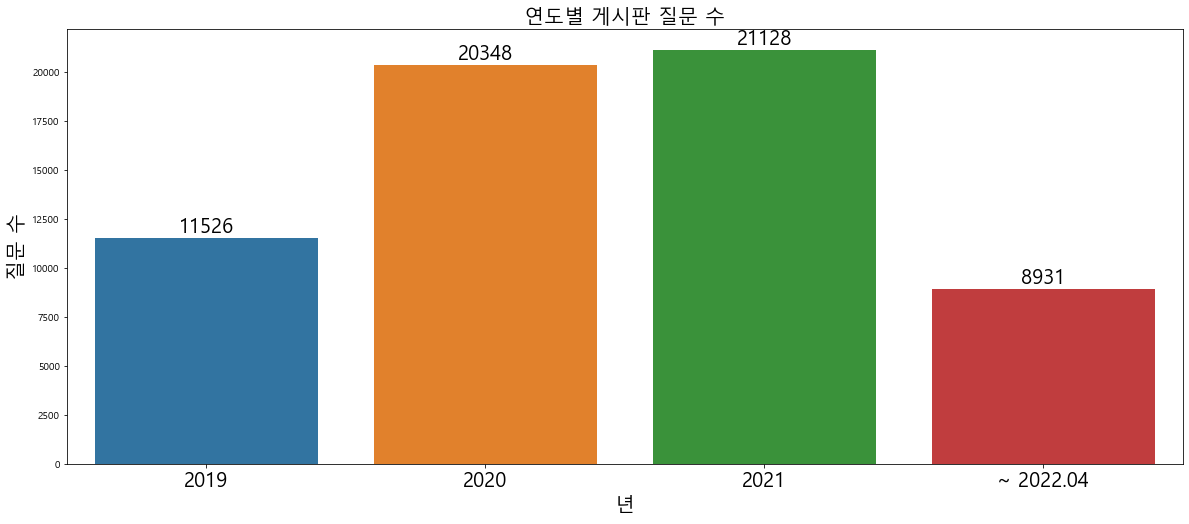

In [496]:
labels = ['2019', '2020', '2021', '~ 2022.04']
ax = sns.barplot(x = 'year', y = 'Q_cnt', data = yearly_Q_cnt)
ax.figure.set_size_inches(20 ,8)
ax.set_ylabel('질문 수', fontsize = 20)
ax.set_xlabel('년', fontsize = 20);
ax.set_title('연도별 게시판 질문 수'.format(yr), fontsize = 20)
ax.set_xticklabels(labels, fontsize = 20)
ax.bar_label(ax.containers[0], size = 20)
plt.show();

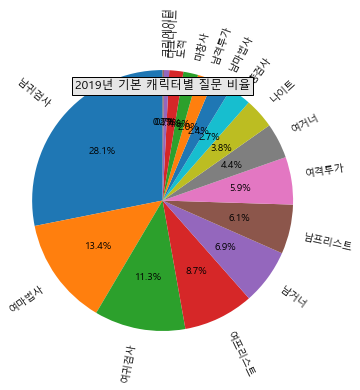

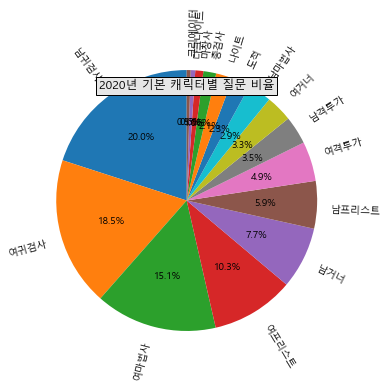

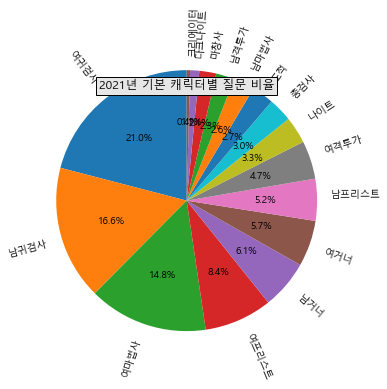

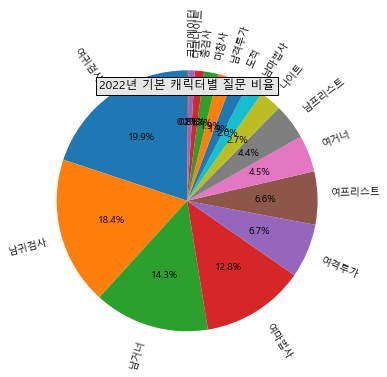

In [498]:
basic_char_yearly_list = [basic_char_Q_cnt_19, basic_char_Q_cnt_20,
                    basic_char_Q_cnt_21, basic_char_Q_cnt_22]
yr = 2019
for i in basic_char_yearly_list:
    ratio = i.Q_cnt.values.tolist()
    labels = i.char.values.tolist()
    plt.title("{}년 기본 캐릭터별 질문 비율".format(yr), pad = 3, bbox={'facecolor':'0.9', 'pad':3})
    plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle = 90, textprops = {'fontsize': 10}, radius = 1.5, rotatelabels =True)
    plt.show()
    yr+=1    

In [499]:
basic_char_Q_cnt_19

,year,char,Q_cnt
3,2019,남귀검사,3242
12,2019,여마법사,1542
11,2019,여귀검사,1302
13,2019,여프리스트,1004
1,2019,남거너,792
5,2019,남프리스트,705
10,2019,여격투가,679
9,2019,여거너,504
0,2019,나이트,434
14,2019,총검사,316


In [500]:
basic_char_Q_cnt_20

,year,char,Q_cnt
19,2020,남귀검사,4072
27,2020,여귀검사,3763
28,2020,여마법사,3066
29,2020,여프리스트,2093
17,2020,남거너,1560
21,2020,남프리스트,1198
26,2020,여격투가,999
18,2020,남격투가,709
25,2020,여거너,670
20,2020,남마법사,594


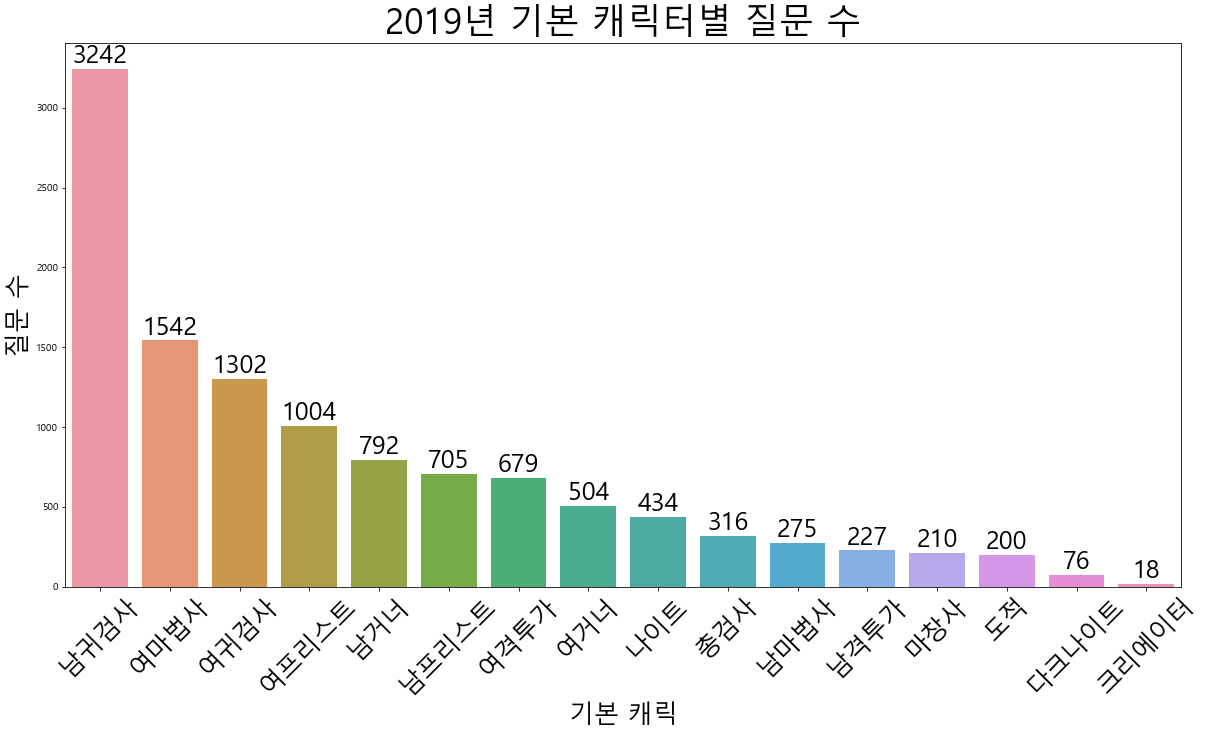

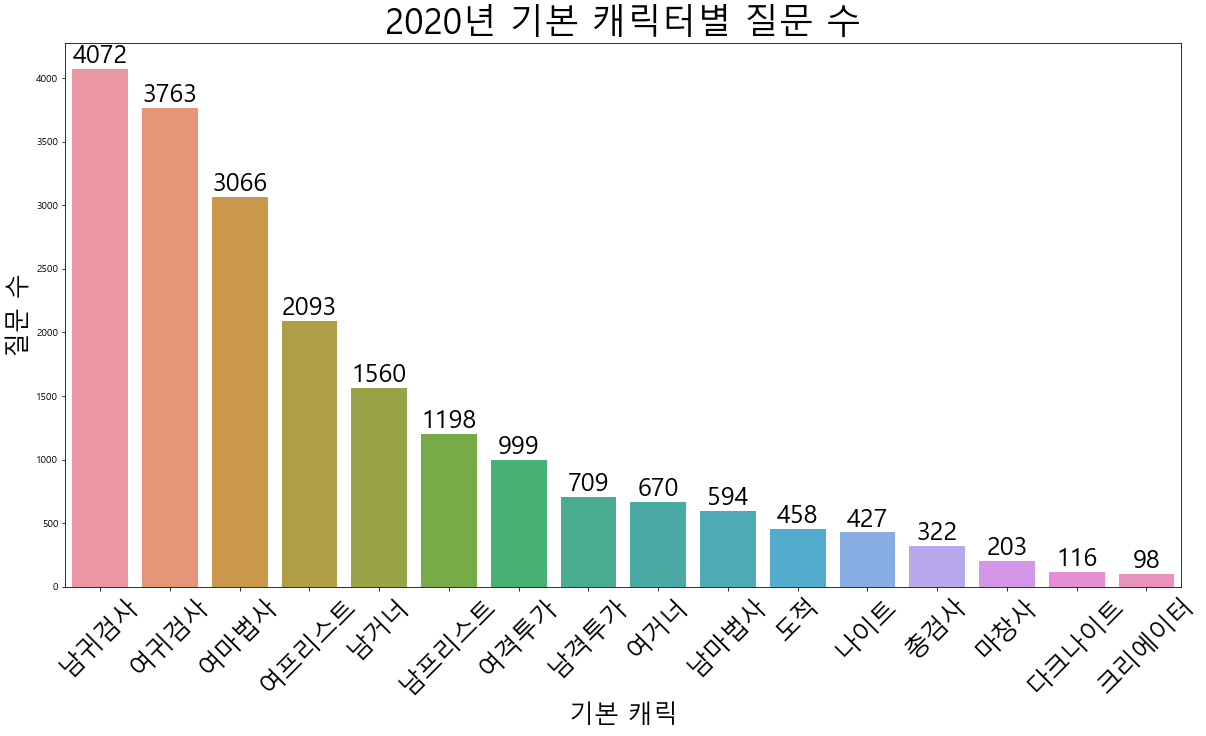

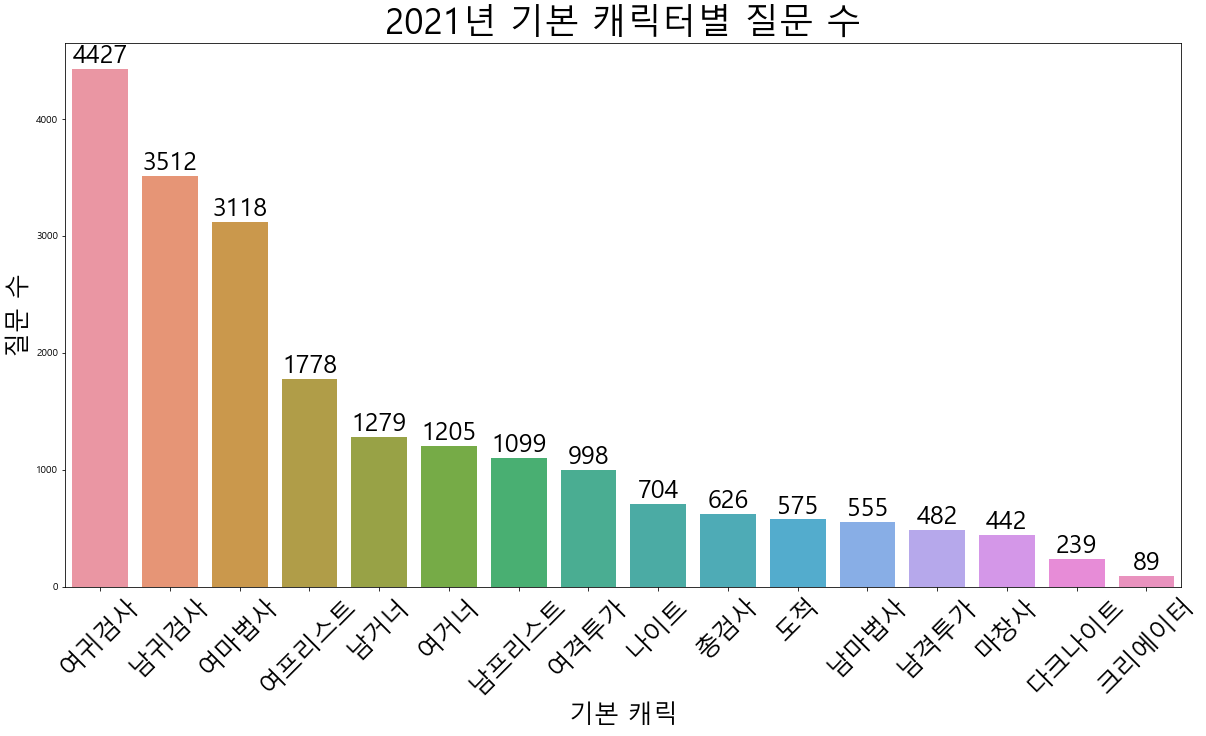

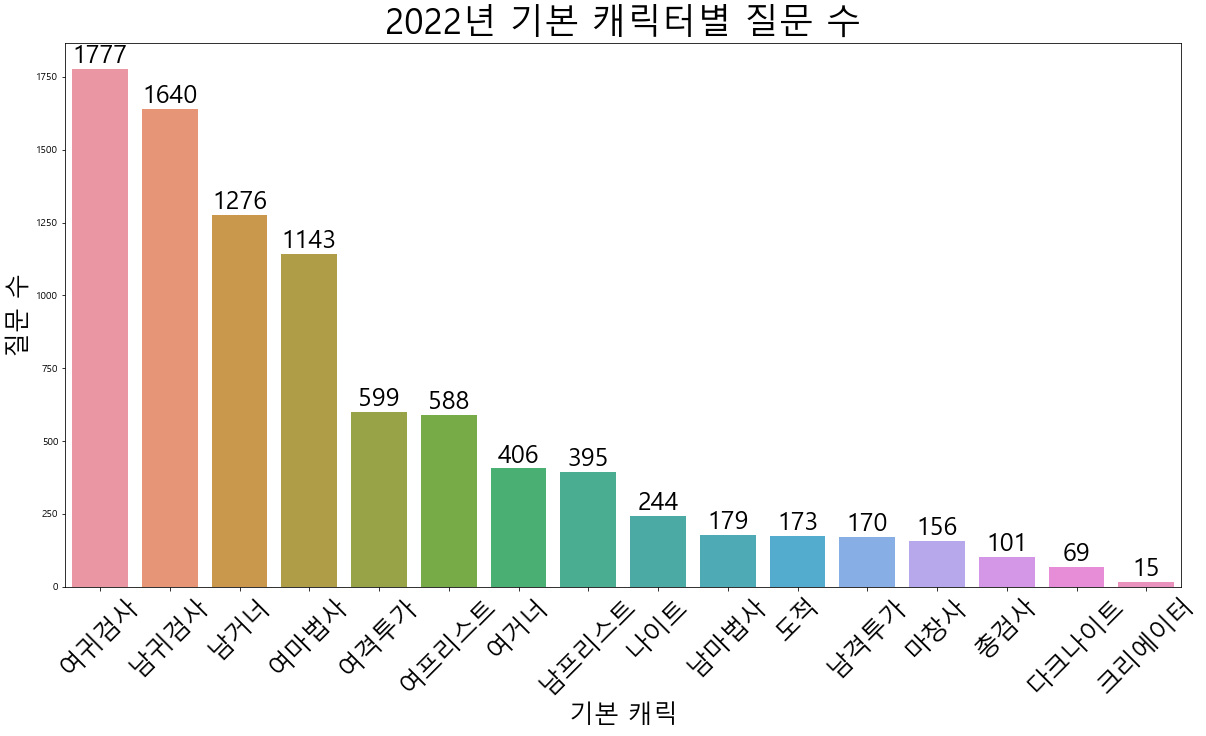

In [501]:
basic_char_yearly_list = [basic_char_Q_cnt_19, basic_char_Q_cnt_20,
                          basic_char_Q_cnt_21, basic_char_Q_cnt_22]
yr = 2019

for i in range(len(basic_char_yearly_list)):
    ax = sns.barplot(x = 'char', y = 'Q_cnt', data = basic_char_yearly_list[i])
    labels = basic_char_yearly_list[i]['char'].values.tolist()
    ax.figure.set_size_inches(20 ,10)
    ax.set_ylabel('질문 수', fontsize = 25)
    ax.set_xlabel('기본 캐릭', fontsize = 25);
    ax.set_title('{}년 기본 캐릭터별 질문 수'.format(yr), fontsize = 35)
    ax.set_xticklabels(labels, rotation = 45, fontsize = 25)
    ax.bar_label(ax.containers[0], size = 25)
    yr+=1
    plt.show();

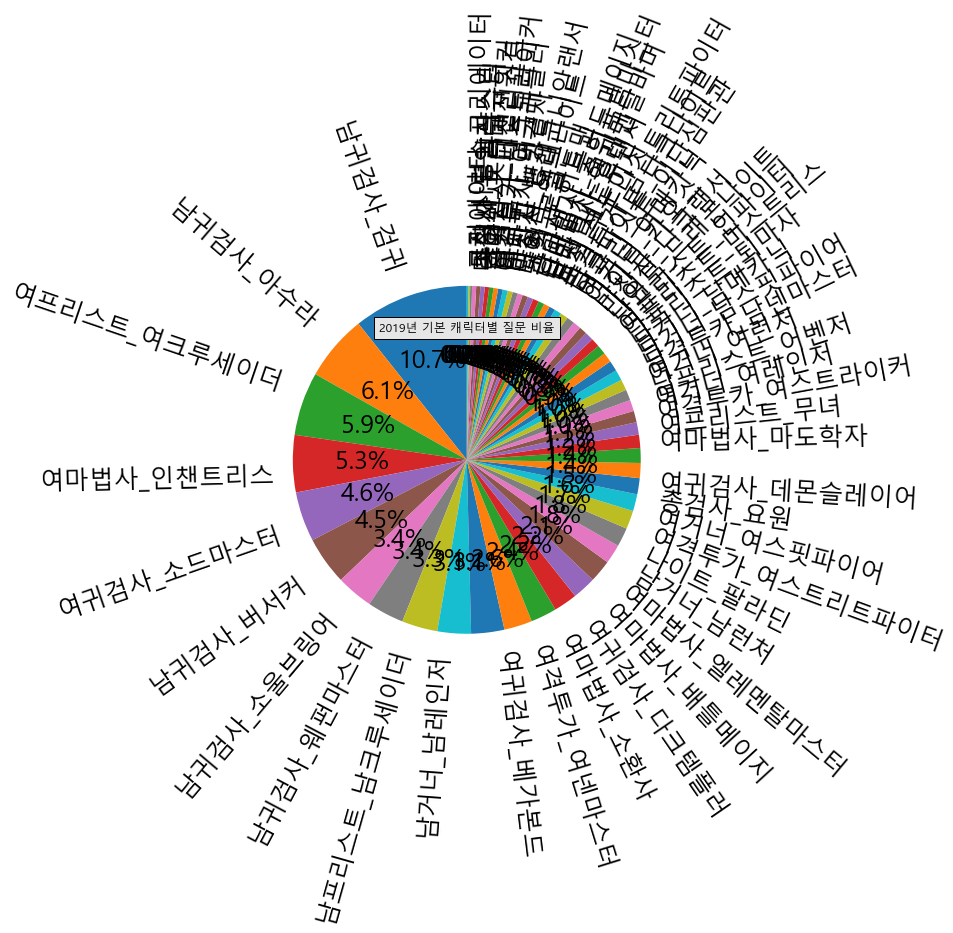

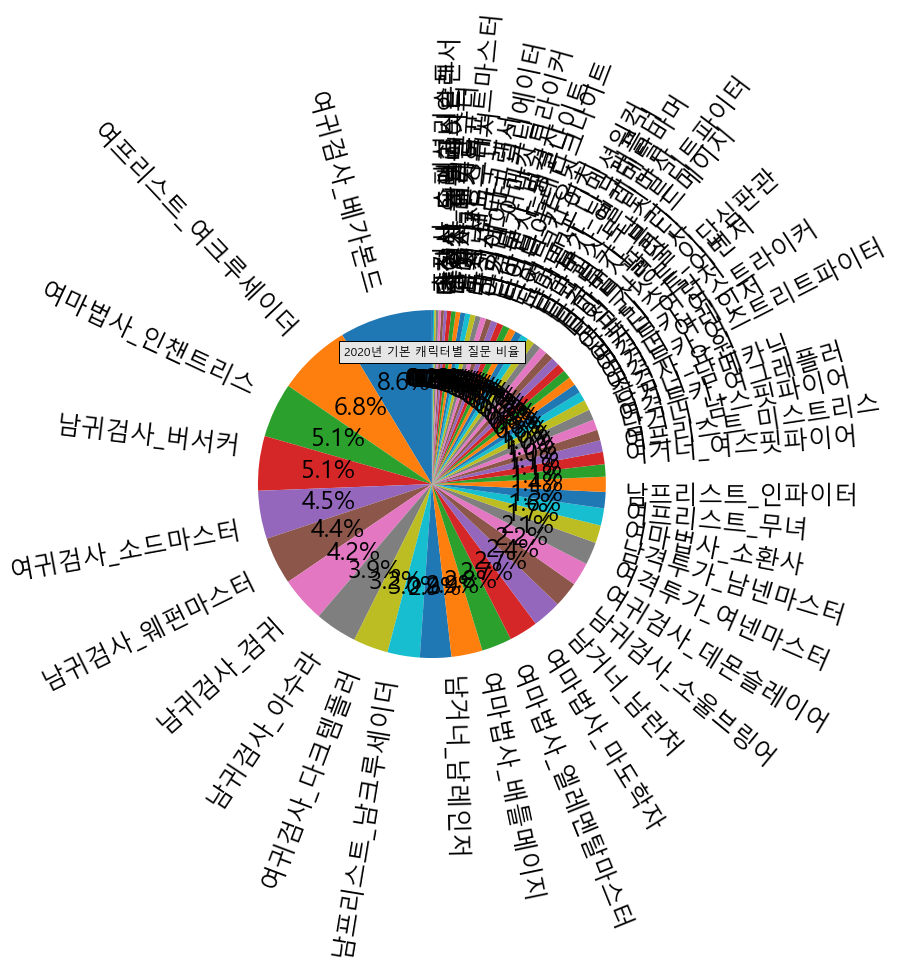

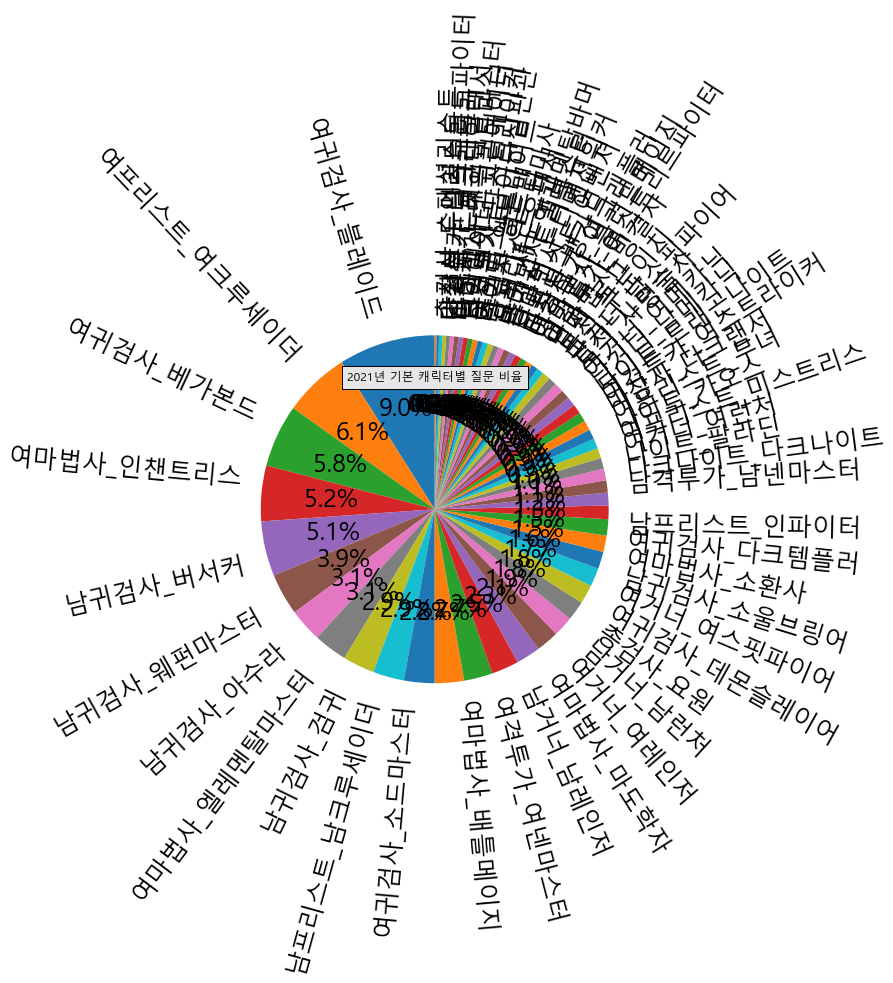

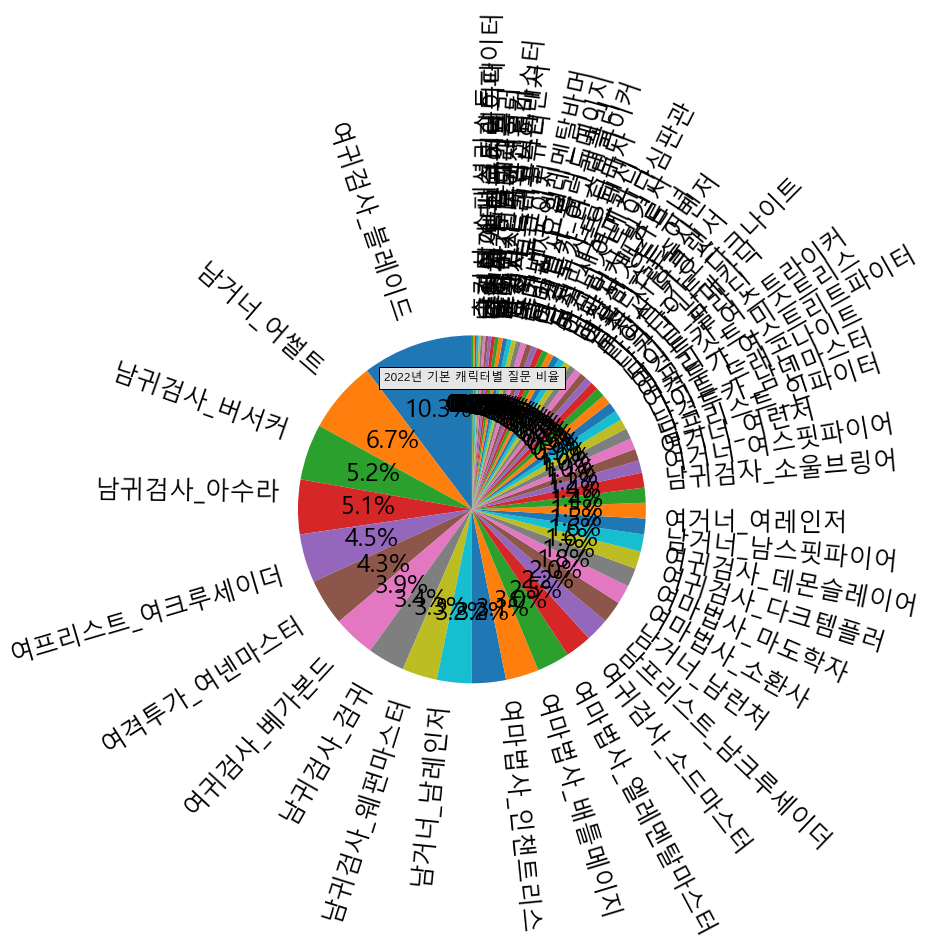

In [507]:
detailed_char_yearly_list = [detailed_char_Q_cnt_19, detailed_char_Q_cnt_20,
                    detailed_char_Q_cnt_21, detailed_char_Q_cnt_22]
yr = 2019
for i in detailed_char_yearly_list:
    ratio = i.Q_cnt.values.tolist()
    labels = i.character.values.tolist()
    plt.title("{}년 기본 캐릭터별 질문 비율".format(yr), pad = 20, bbox={'facecolor':'0.9', 'pad':5})
    plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle = 90, textprops = {'fontsize': 25}, radius = 2, rotatelabels =True)
    plt.show()
    yr+=1    

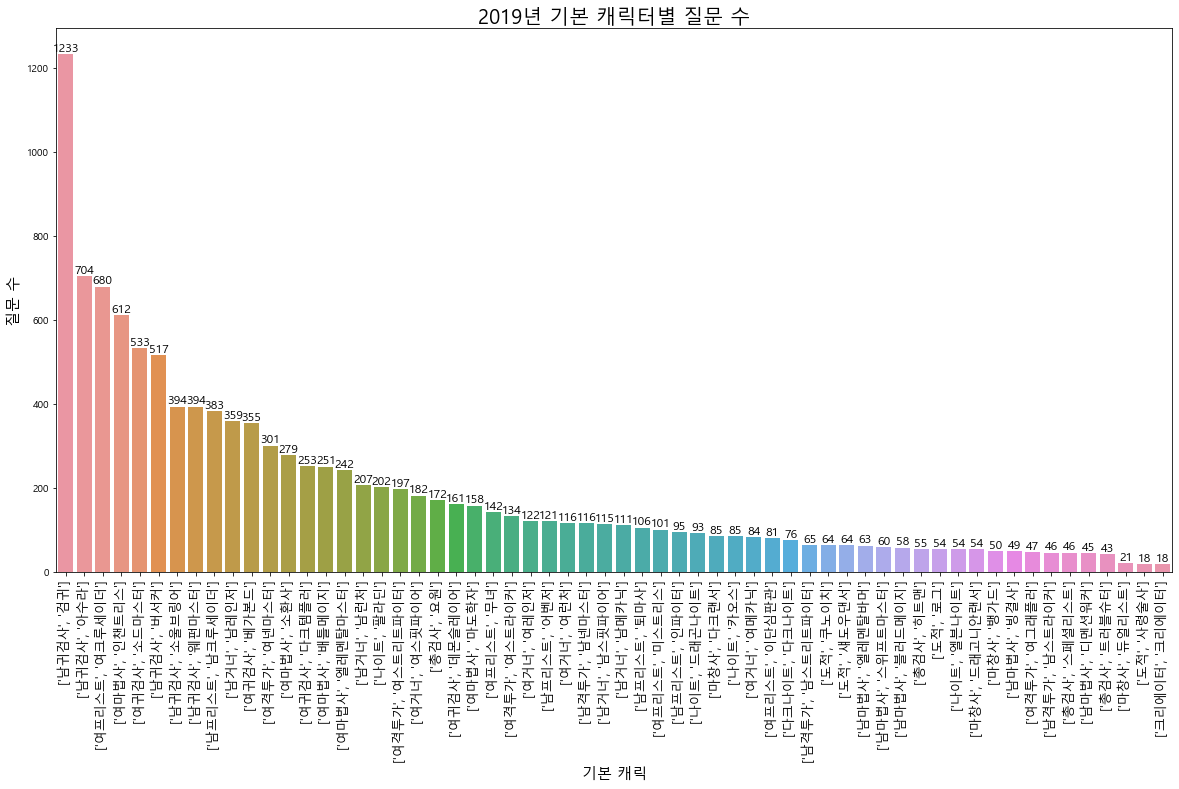

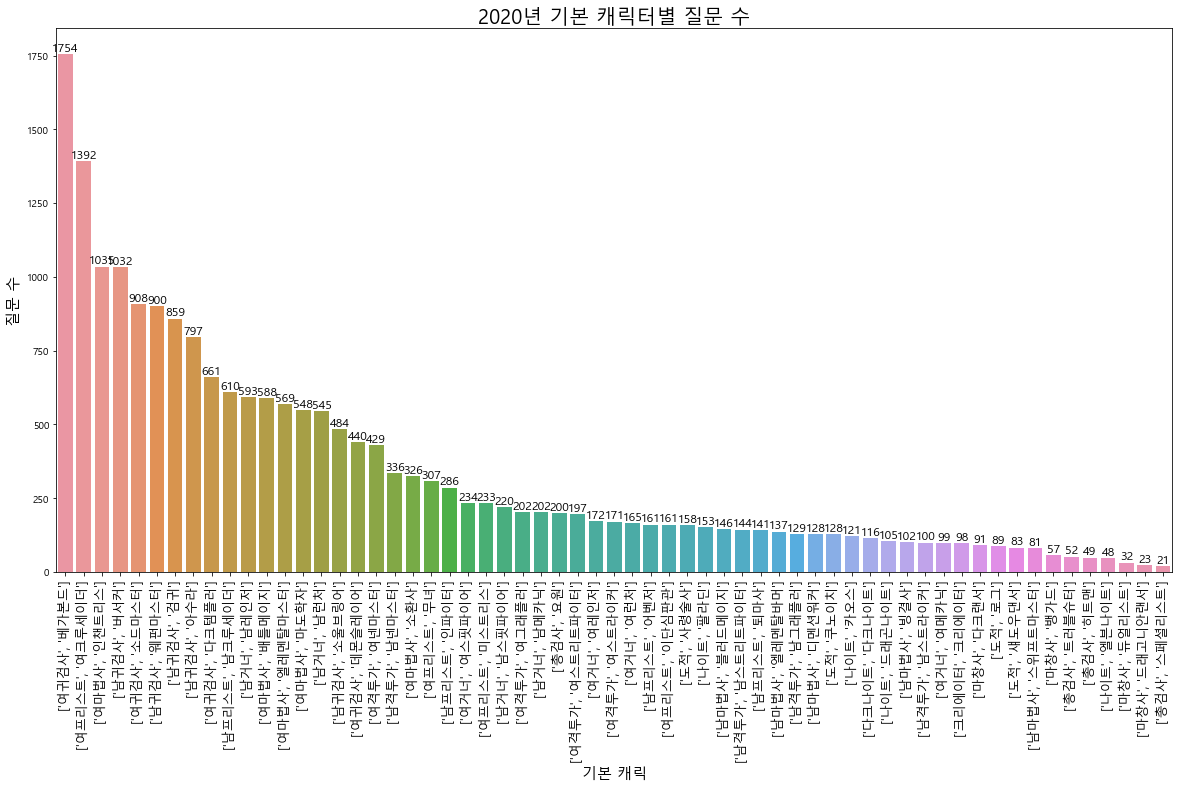

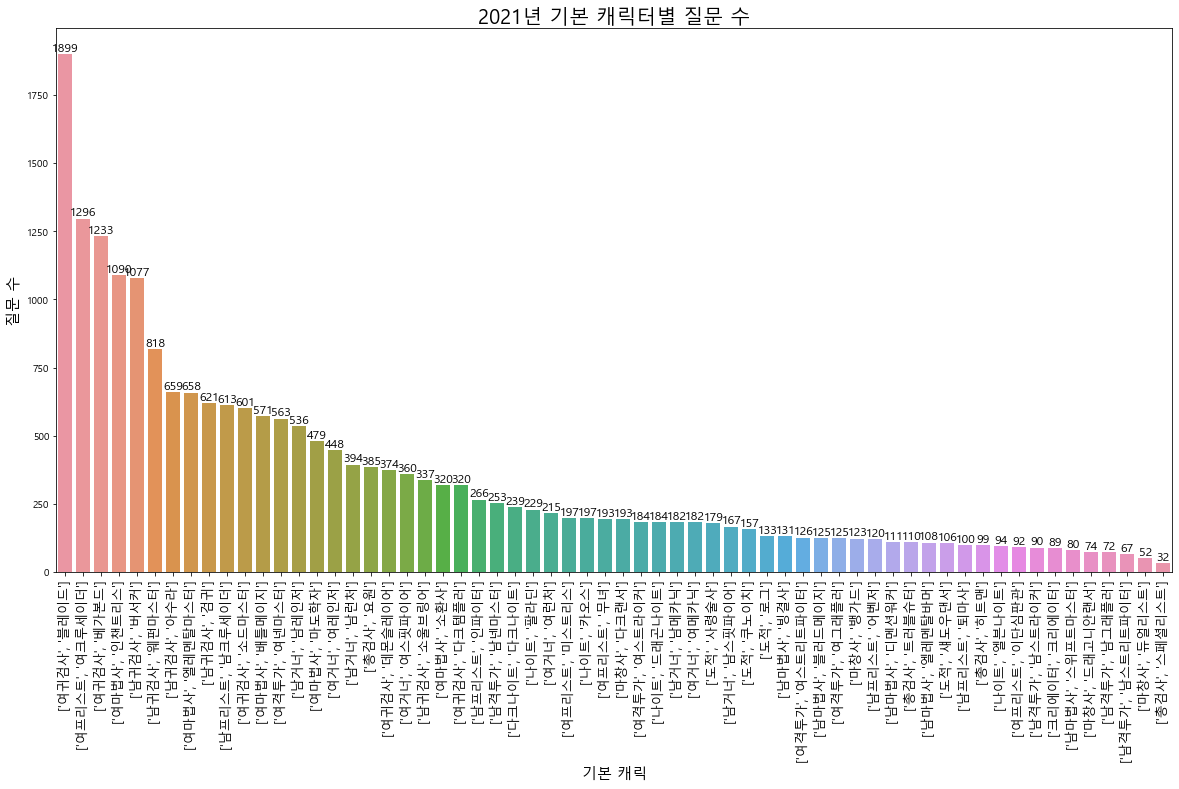

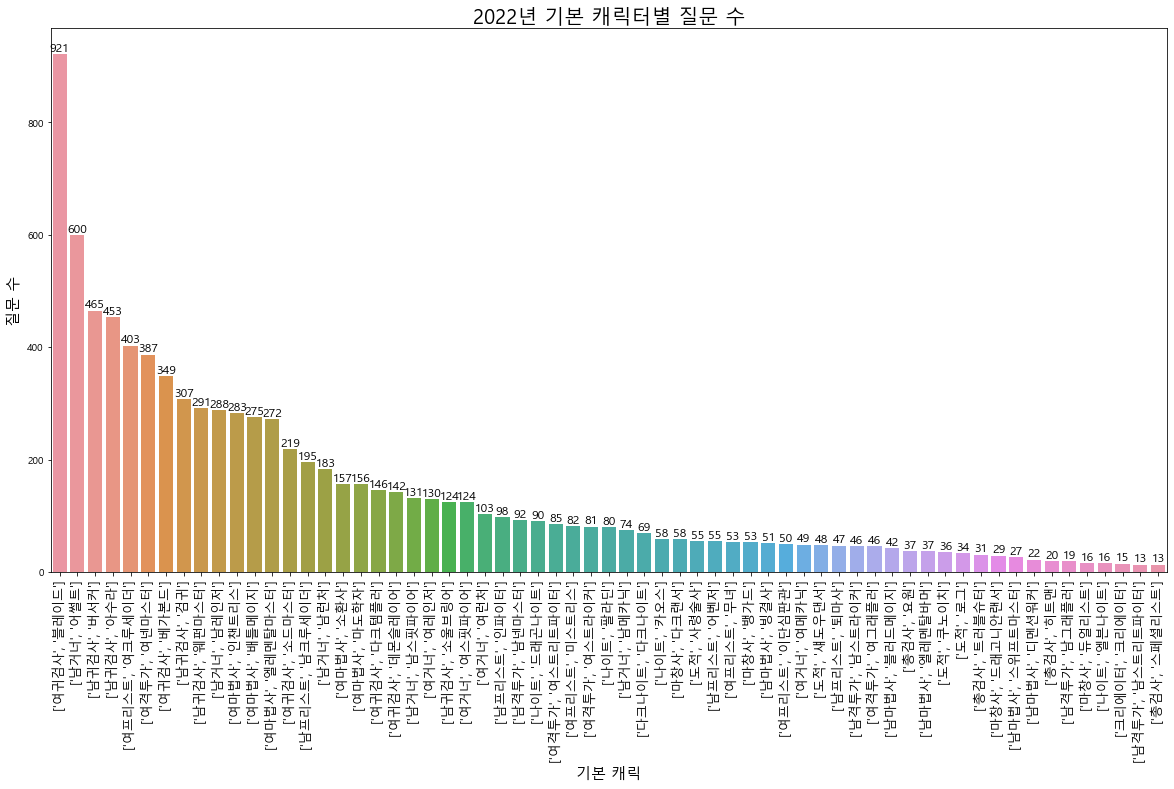

In [489]:
detailed_char_yearly_list = [detailed_char_Q_cnt_19, detailed_char_Q_cnt_20,
                          detailed_char_Q_cnt_21, detailed_char_Q_cnt_22]
yr = 2019

for i in range(len(detailed_char_yearly_list)):
    labels = detailed_char_yearly_list[i][['char','detailed_char']].values.tolist()
    ax = sns.barplot(x = 'detailed_char', y = 'Q_cnt', data = detailed_char_yearly_list[i])
    ax.figure.set_size_inches(20 ,10)
    ax.set_ylabel('질문 수', fontsize = 15)
    ax.set_xlabel('기본 캐릭', fontsize = 15)
    ax.set_xticklabels(labels, rotation = 90, fontsize = 13)
    ax.set_title('{}년 기본 캐릭터별 질문 수'.format(yr), fontsize = 20)
    ax.bar_label(ax.containers[0], size = 12)
    yr+=1
    plt.show();

# 4. 캐릭터별 질문 주요 키워드

In [419]:
df_total_rev = df_total.copy()
df_total_rev

,character,char,detailed_char,Title,year,date,views
0,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 다시 한번 짜본 상변X 검신 조언 좀 ...,2022,04-26,47
1,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 웨펀 류심 의 메커니즘을잘 모르고 소검...,2022,04-26,84
2,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 복귀한 던린이입니다 극감전셋 하고싶은데...,2022,04-25,63
3,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 굴착기 리귀검술 \...,2022,04-24,239
4,남귀검사_웨펀마스터,남귀검사,웨펀마스터,\n\n [질문] 웨펀둔기 \n(3) \n,2022,04-24,108
...,...,...,...,...,...,...,...
83343,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 패파는 무슨 속성을 타는게 나중에 유리...,2019,01-11,1111
83344,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 던린이 패파가 할렘방어구에 대해 질문이...,2019,01-11,726
83345,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 장비 질문쫌 드려요~ ...,2019,01-11,549
83346,총검사_스페셜리스트,총검사,스페셜리스트,\n\n [질문] 페파 보조장비맞추고있는데... ...,2019,01-04,497


### 질문 제목 내 분석에 무의미한 단어 제거

In [420]:
# 질문 제목 내 [질문], \n\n 제거
df_total_rev['Title'] = df_total_rev['Title'].apply(lambda x : x.replace('[질문]', '').replace('\n',''))
df_total_rev

,character,char,detailed_char,Title,year,date,views
0,남귀검사_웨펀마스터,남귀검사,웨펀마스터,다시 한번 짜본 상변X 검신 조언 좀 ...,2022,04-26,47
1,남귀검사_웨펀마스터,남귀검사,웨펀마스터,웨펀 류심 의 메커니즘을잘 모르고 소검과 둔기 도를 ...,2022,04-26,84
2,남귀검사_웨펀마스터,남귀검사,웨펀마스터,복귀한 던린이입니다 극감전셋 하고싶은데 에픽 이름이 ...,2022,04-25,63
3,남귀검사_웨펀마스터,남귀검사,웨펀마스터,굴착기 리귀검술 (4),2022,04-24,239
4,남귀검사_웨펀마스터,남귀검사,웨펀마스터,웨펀둔기 (3),2022,04-24,108
...,...,...,...,...,...,...,...
83343,총검사_스페셜리스트,총검사,스페셜리스트,패파는 무슨 속성을 타는게 나중에 유리할까요? ...,2019,01-11,1111
83344,총검사_스페셜리스트,총검사,스페셜리스트,던린이 패파가 할렘방어구에 대해 질문이 있습니다! ...,2019,01-11,726
83345,총검사_스페셜리스트,총검사,스페셜리스트,장비 질문쫌 드려요~ (5),2019,01-11,549
83346,총검사_스페셜리스트,총검사,스페셜리스트,페파 보조장비맞추고있는데... (5),2019,01-04,497


In [421]:
## 한국어 형태소 분석기 중 Mecab이 가장 빠르고 높은 정확도를 보인다고 판단되어 Mecab으로 진행함

# 사용하고자 하는 품사 선택
FEATURES =['NNG', 'NNP', 'NNB', 'NP'] ## 명사
# FEATURES =['NNG', 'NNP', 'NNB', 'NP', 'VV', 'VA', 'VCP','VCN', 'MAG', 'MAJ'] ## 명사, 동사, 형용사, 부사
mecab = Mecab()

#불용어목록

stopwords = ['의','가','이','은','들','는','잘','걍','과','도', '를','으로','자','에','와','한','하다','을','에서','해서', '것', '질문', '있',
             '남그', '런처', '레인저',  '레인져', '메카', '메카닉', '패', '황', '스트라이커', '스파', '크루세이더', '크루', '프리',
             '다크', '나이트',  '랜서', '레이어', '여귀', '듀얼', '듀란', '드', '드래곤', '디멘션', '로그', '마도', '학자', '무녀', 
             '미스트', '리스', '미스트리', '리디', '배틀', '메이지', '뱅가드',  '베가', '본드', '블', '블러드', '결사', '빙결', 
             '사령', '술사', '소드', '마스터', '소마', '소울', '브링', '링어', '소환', '스마', '스위프트', '스페셜', '리스트',
             '아수라', '수라', '어벤져', '어썰트', '엘마', '엘바', '여그', '여스', '요원', '이단', '심판관', '판관', '트리스', 
             '인파', '인파이터','카오스', '키오스', '쿠노', '쿠노이치', '크리', '크리에이터', '퇴마', '트러블', '팔라딘', '히트맨', '블레이드']

# ㅋㅋㅋ, ^, . 등 특수 문자 및 무의미한 단어들을 제거하고 주요 키워드를 뽑아내기 위해 명사만 추출

def select_words(text):
    text = text.strip()
    mecab_morphs = mecab.pos(text)
    selected_words=[]
    for word, pos in mecab_morphs:
        if pos in FEATURES and word not in stopwords: #명사만 추출 + 분석에 방해되는 불용어 제거
            selected_words.append(word)
    return ' '.join(selected_words)

df_total_rev['Title'] = df_total_rev['Title'].apply(lambda x : select_words(x))
df_total_rev

,character,char,detailed_char,Title,year,date,views
0,남귀검사_웨펀마스터,남귀검사,웨펀마스터,상변 검신 조언,2022,04-26,47
1,남귀검사_웨펀마스터,남귀검사,웨펀마스터,웨 펀 메커니즘 소검 둔기 대체,2022,04-26,84
2,남귀검사_웨펀마스터,남귀검사,웨펀마스터,복귀 린이 극감 전 데 이름,2022,04-25,63
3,남귀검사_웨펀마스터,남귀검사,웨펀마스터,굴착기 리 귀 검술,2022,04-24,239
4,남귀검사_웨펀마스터,남귀검사,웨펀마스터,웨 펀 둔기,2022,04-24,108
...,...,...,...,...,...,...,...
83343,총검사_스페셜리스트,총검사,스페셜리스트,파 속성 나중 유리,2019,01-11,1111
83344,총검사_스페셜리스트,총검사,스페셜리스트,린 파가 렘 방어구,2019,01-11,726
83345,총검사_스페셜리스트,총검사,스페셜리스트,장비,2019,01-11,549
83346,총검사_스페셜리스트,총검사,스페셜리스트,페파 보조 장비,2019,01-04,497


### 연도별 주요 키워드 추출

In [422]:
df_total_rev_19 = df_total_rev[df_total_rev.year == 2019]
df_total_rev_20 = df_total_rev[df_total_rev.year == 2020]
df_total_rev_21 = df_total_rev[df_total_rev.year == 2021]
df_total_rev_22 = df_total_rev[df_total_rev.year == 2022]

In [423]:
character_list = ['남귀검사_웨펀마스터','남귀검사_소울브링어','남귀검사_버서커', '남귀검사_아수라', '남귀검사_검귀', 
                  '여귀검사_소드마스터', '여귀검사_데몬슬레이어', '여귀검사_베가본드', '여귀검사_다크템플러', '여귀검사_블레이드', 
                  '남격투가_남넨마스터', '남격투가_남스트라이커', '남격투가_남스트리트파이터', '남격투가_남그래플러', 
                  '여격투가_여넨마스터', '여격투가_여스트라이커', '여격투가_여스트리트파이터', '여격투가_여그래플러',
                  '남거너_남레인저', '남거너_남런처', '남거너_남메카닉', '남거너_남스핏파이어', '남거너_어썰트', 
                  '여거너_여레인저','여거너_여런처', '여거너_여메카닉', '여거너_여스핏파이어', 
                  '남마법사_엘레멘탈바머', '남마법사_빙결사', '남마법사_블러드메이지', '남마법사_스위프트마스터', '남마법사_디멘션워커', 
                  '여마법사_엘레멘탈마스터', '여마법사_소환사', '여마법사_배틀메이지','여마법사_마도학자', '여마법사_인챈트리스', 
                  '남프리스트_남크루세이더', '남프리스트_인파이터', '남프리스트_퇴마사','남프리스트_어벤저', 
                  '여프리스트_여크루세이더', '여프리스트_이단심판관', '여프리스트_무녀', '여프리스트_미스트리스',
                  '도적_로그', '도적_사령술사', '도적_쿠노이치', '도적_섀도우댄서', '나이트_엘븐나이트', '나이트_카오스', '나이트_팔라딘',
                  '나이트_드래곤나이트', '다크나이트_다크나이트', '크리에이터_크리에이터', '마창사_뱅가드', '마창사_듀얼리스트',
                  '마창사_드래고니안랜서', '마창사_다크랜서', '총검사_히트맨', '총검사_요원', '총검사_트러블슈터', '총검사_스페셜리스트']
yr = 19

for i in [df_total_rev_19, df_total_rev_20, df_total_rev_21, df_total_rev_22]:
    for j in character_list:
        globals()[j+str(yr)] = i[i.character == j].Title.tolist()
        
        total_words_list = []
        
        for k in globals()[j+str(yr)]:
            words_list = k.split(' ')
            for l in words_list:
                if len(l)>=2:
                    total_words_list.append(l)

        globals()[j+str(yr)] = Counter(total_words_list).most_common()[:20]
    yr+=1

In [424]:
남귀검사_웨펀마스터19

[('검신', 52),
 ('테이', 25),
 ('프레이', 23),
 ('복귀', 22),
 ('계절', 20),
 ('오광', 18),
 ('방어구', 16),
 ('가능', 12),
 ('진로', 12),
 ('스위칭', 11),
 ('스킬', 10),
 ('가요', 10),
 ('스펙', 10),
 ('유저', 10),
 ('광검', 9),
 ('순서', 9),
 ('창천', 9),
 ('마부', 9),
 ('부탁', 8),
 ('탈리스', 8)]

In [425]:
character_list = ['남귀검사_웨펀마스터','남귀검사_소울브링어','남귀검사_버서커', '남귀검사_아수라', '남귀검사_검귀', 
                  '여귀검사_소드마스터', '여귀검사_데몬슬레이어', '여귀검사_베가본드', '여귀검사_다크템플러', '여귀검사_블레이드', 
                  '남격투가_남넨마스터', '남격투가_남스트라이커', '남격투가_남스트리트파이터', '남격투가_남그래플러', 
                  '여격투가_여넨마스터', '여격투가_여스트라이커', '여격투가_여스트리트파이터', '여격투가_여그래플러',
                  '남거너_남레인저', '남거너_남런처', '남거너_남메카닉', '남거너_남스핏파이어', '남거너_어썰트', 
                  '여거너_여레인저','여거너_여런처', '여거너_여메카닉', '여거너_여스핏파이어', 
                  '남마법사_엘레멘탈바머', '남마법사_빙결사', '남마법사_블러드메이지', '남마법사_스위프트마스터', '남마법사_디멘션워커', 
                  '여마법사_엘레멘탈마스터', '여마법사_소환사', '여마법사_배틀메이지','여마법사_마도학자', '여마법사_인챈트리스', 
                  '남프리스트_남크루세이더', '남프리스트_인파이터', '남프리스트_퇴마사','남프리스트_어벤저', 
                  '여프리스트_여크루세이더', '여프리스트_이단심판관', '여프리스트_무녀', '여프리스트_미스트리스',
                  '도적_로그', '도적_사령술사', '도적_쿠노이치', '도적_섀도우댄서', '나이트_엘븐나이트', '나이트_카오스', '나이트_팔라딘',
                  '나이트_드래곤나이트', '다크나이트_다크나이트', '크리에이터_크리에이터', '마창사_뱅가드', '마창사_듀얼리스트',
                  '마창사_드래고니안랜서', '마창사_다크랜서', '총검사_히트맨', '총검사_요원', '총검사_트러블슈터', '총검사_스페셜리스트']
yr = 19

for yr in [19, 20, 21, 22]:
    for i in character_list:
        if i == '남귀검사_웨펀마스터':
            globals()['main_keywords_'+str(yr)] = pd.DataFrame([globals()[i+str(yr)]])
        else:
            globals()['main_keywords_'+str(yr)] = pd.concat([globals()['main_keywords_'+str(yr)], pd.DataFrame([globals()[i+str(yr)]])])
    globals()['main_keywords_'+str(yr)] = globals()['main_keywords_'+str(yr)].transpose()
    globals()['main_keywords_'+str(yr)].columns = character_list
    globals()['main_keywords_'+str(yr)].to_excel('연도별 캐릭터별 주요 질문 키워드_'+str(yr)+'.xlsx')
main_keywords_19

,남귀검사_웨펀마스터,남귀검사_소울브링어,남귀검사_버서커,남귀검사_아수라,남귀검사_검귀,여귀검사_소드마스터,여귀검사_데몬슬레이어,여귀검사_베가본드,여귀검사_다크템플러,여귀검사_블레이드,...,다크나이트_다크나이트,크리에이터_크리에이터,마창사_뱅가드,마창사_듀얼리스트,마창사_드래고니안랜서,마창사_다크랜서,총검사_히트맨,총검사_요원,총검사_트러블슈터,총검사_스페셜리스트
0,"(검신, 52)","(프레이, 44)","(테이, 57)","(테이, 94)","(테이, 112)","(테이, 53)","(테이, 24)","(광검, 44)","(테이, 25)",NaN,...,"(방어구, 12)","(테이, 5)","(로드, 15)","(란달, 8)","(제노, 10)","(테이, 10)","(갓파더, 7)","(테이, 23)","(테이, 6)","(방어구, 6)"
1,"(테이, 25)","(린이, 25)","(프레이, 37)","(프레이, 47)","(장비, 53)","(복귀, 41)","(프레이, 10)","(무기, 33)","(프레이, 19)",NaN,...,"(마공, 12)","(탈리스, 2)","(할렘, 5)","(테이, 4)","(테이, 10)","(프레이, 5)","(테이, 6)","(방어구, 17)","(창천, 5)","(추천, 6)"
2,"(프레이, 23)","(테이, 25)","(방어구, 30)","(방어구, 42)","(프레이, 50)","(대검, 38)","(억년, 8)","(테이, 33)","(가능, 14)",NaN,...,"(무기, 7)","(방어구, 2)","(방어구, 4)","(이베르, 2)","(무기, 4)","(스킬, 4)","(창천, 4)","(오광, 14)","(오광, 4)","(장비, 5)"
3,"(복귀, 22)","(가능, 18)","(복귀, 27)","(계절, 40)","(칭호, 47)","(소검, 33)","(오광, 8)","(방어구, 32)","(방어구, 14)",NaN,...,"(복귀, 6)","(장비, 2)","(오광, 4)","(방어구, 2)","(천공, 4)","(스펙, 4)","(오광, 4)","(추천, 10)","(방어구, 3)","(패스파인더, 4)"
4,"(계절, 20)","(칭호, 16)","(계절, 24)","(칭호, 39)","(가능, 45)","(프레이, 31)","(방어구, 8)","(오광, 30)","(칭호, 13)",NaN,...,"(소검, 5)","(크리티컬, 1)","(테이, 4)","(부족, 2)","(방어구, 3)","(이번, 3)","(스위칭, 3)","(프레이, 9)","(슬롯, 3)","(테이, 4)"
5,"(오광, 18)","(악세, 16)","(스펙, 22)","(복귀, 34)","(마부, 44)","(방어구, 29)","(순서, 7)","(대검, 24)","(창천, 11)",NaN,...,"(테이, 4)","(오광, 1)","(세트, 3)","(스킬, 2)","(할렘, 3)","(잠식, 3)","(가요, 3)","(계절, 9)","(추천, 3)","(부탁, 3)"
6,"(방어구, 16)","(계절, 16)","(가능, 21)","(가능, 31)","(린이, 44)","(유저, 24)","(무기, 7)","(린이, 20)","(무기, 9)",NaN,...,"(계절, 4)","(계절, 1)","(가요, 2)","(시작, 2)","(오광, 3)","(가능, 3)","(칭호, 3)","(악세, 8)","(이번, 2)","(칭호, 3)"
7,"(가능, 12)","(스펙, 15)","(스킬, 19)","(오광, 28)","(방어구, 39)","(창천, 24)","(복귀, 7)","(계절, 20)","(스펙, 9)",NaN,...,"(유저, 3)","(무기, 1)","(억년, 2)","(오광, 2)","(억년, 3)","(루크, 3)","(고민, 3)","(탈리스, 6)","(슈터, 2)","(오광, 2)"
8,"(진로, 12)","(스킬, 14)","(무기, 18)","(마부, 23)","(할렘, 39)","(가능, 22)","(스킬, 6)","(고민, 12)","(네메, 9)",NaN,...,"(프레이, 3)","(속강, 1)","(탈리스, 2)","(추천, 2)","(광창, 2)","(패치, 2)","(할렘, 3)","(부탁, 6)","(계절, 2)","(창천, 2)"
9,"(스위칭, 11)","(스위칭, 13)","(추천, 16)","(유저, 20)","(악세, 34)","(마부, 22)","(트리, 6)","(칭호, 12)","(오광, 8)",NaN,...,"(시작, 3)","(아바타, 1)","(창천, 2)","(태양, 1)","(스위칭, 2)","(어디, 2)","(유저, 2)","(무기, 6)","(언터쳐블, 1)","(코어, 2)"


In [426]:
main_keywords_20

,남귀검사_웨펀마스터,남귀검사_소울브링어,남귀검사_버서커,남귀검사_아수라,남귀검사_검귀,여귀검사_소드마스터,여귀검사_데몬슬레이어,여귀검사_베가본드,여귀검사_다크템플러,여귀검사_블레이드,...,다크나이트_다크나이트,크리에이터_크리에이터,마창사_뱅가드,마창사_듀얼리스트,마창사_드래고니안랜서,마창사_다크랜서,총검사_히트맨,총검사_요원,총검사_트러블슈터,총검사_스페셜리스트
0,"(검신, 73)","(무기, 45)","(무기, 120)","(무기, 73)","(신화, 54)","(스펙, 50)","(복귀, 27)","(무기, 151)","(무기, 48)",NaN,...,"(무기, 8)","(무기, 13)","(로드, 11)","(세팅, 2)","(제노, 3)","(칭호, 7)","(무기, 8)","(선택, 18)","(신화, 5)","(아바타, 3)"
1,"(복귀, 53)","(시로코, 32)","(복귀, 58)","(복귀, 54)","(무기, 34)","(복귀, 49)","(시로코, 24)","(칭호, 86)","(신화, 36)",NaN,...,"(고수, 7)","(신화, 9)","(무기, 6)","(초월, 2)","(가능, 2)","(무기, 6)","(시작, 4)","(신화, 17)","(홍염, 4)","(베투스, 3)"
2,"(무기, 52)","(신화, 29)","(신화, 53)","(신화, 42)","(세팅, 34)","(세팅, 46)","(신화, 23)","(세팅, 81)","(복귀, 31)",NaN,...,"(신화, 7)","(선택, 6)","(수문장, 4)","(란달, 2)","(결장, 2)","(시로코, 4)","(탈리스, 4)","(세팅, 17)","(슈터, 4)","(패스파인더, 3)"
3,"(신화, 44)","(복귀, 19)","(세팅, 52)","(시로코, 38)","(린이, 33)","(신화, 45)","(가능, 20)","(린이, 79)","(시로코, 31)",NaN,...,"(복귀, 7)","(세팅, 6)","(종결, 4)","(조언, 2)","(광창, 2)","(시너지, 4)","(복귀, 3)","(무기, 10)","(무기, 4)","(무기, 2)"
4,"(세팅, 36)","(가능, 18)","(태극, 35)","(유저, 35)","(복귀, 31)","(무기, 39)","(무기, 18)","(스펙, 66)","(스펙, 30)",NaN,...,"(관련, 6)","(복귀, 4)","(부탁, 4)","(스킬, 2)","(사이, 2)","(신화, 4)","(파밍, 3)","(탈리스, 9)","(아토믹, 3)","(코르, 2)"
5,"(시로코, 34)","(스펙, 17)","(데우스, 34)","(데우스, 30)","(장비, 31)","(가능, 39)","(에픽, 18)","(신화, 65)","(세팅, 26)",NaN,...,"(선택, 5)","(탈리스, 4)","(아바타, 3)","(린이, 2)","(각성, 2)","(에레보스, 4)","(선택, 3)","(스킬, 9)","(아바타, 3)","(스킬, 2)"
6,"(바드, 29)","(추천, 16)","(린이, 34)","(세팅, 29)","(칭호, 31)","(선택, 32)","(린이, 16)","(데우스, 63)","(칭호, 24)",NaN,...,"(마공, 5)","(졸업, 3)","(마부, 3)","(무기, 2)","(무기, 2)","(스킬, 4)","(고민, 2)","(세트, 6)","(트리, 3)","(오버, 2)"
7,"(칭호, 28)","(에픽, 14)","(서커, 28)","(태극, 26)","(스펙, 30)","(대검, 31)","(유저, 15)","(시로코, 63)","(린이, 21)",NaN,...,"(유저, 5)","(사막, 3)","(통곡, 3)","(복귀, 1)","(일렉트로, 2)","(세팅, 4)","(천도, 2)","(파밍, 5)","(레전더리, 3)","(코어, 2)"
8,"(나후, 26)","(세팅, 13)","(스킬, 26)","(탈리스, 23)","(에픽, 30)","(칭호, 29)","(스펙, 13)","(복귀, 61)","(장비, 17)",NaN,...,"(세팅, 4)","(에픽, 3)","(사암, 3)","(탈리스, 1)","(서번트, 1)","(방어구, 4)","(신화, 2)","(영보, 5)","(칭호, 3)","(옵션, 1)"
9,"(스위칭, 26)","(태극, 13)","(에픽, 26)","(스펙, 23)","(아바타, 29)","(시로코, 26)","(칭호, 13)","(바드, 60)","(가능, 17)",NaN,...,"(자연, 4)","(크린, 3)","(주극, 3)","(조사, 1)","(랜스, 1)","(탈리스, 3)","(관련, 2)","(이거, 5)","(스킬, 2)","(목표, 1)"


### WordCloud 이용하여 유저들의 전체 질문 중 어떤 키워드 관련 질문이 많은지 시각화하기

In [431]:
total_words_list = []
        
for i in df_total_rev.Title.tolist():
    words_list = i.split(' ')
    for j in words_list:
        if len(j)>=2:
            total_words_list.append(j)
word_cnt = Counter(total_words_list)
word_cnt

Counter({'상변': 30,
         '검신': 202,
         '조언': 691,
         '메커니즘': 4,
         '소검': 197,
         '둔기': 72,
         '대체': 5,
         '복귀': 2463,
         '린이': 1585,
         '극감': 1,
         '이름': 71,
         '굴착기': 1,
         '검술': 11,
         '가요': 1091,
         '유니크': 78,
         '엠블렘': 227,
         '버츄얼': 3,
         '글래스': 1,
         '굴착': 1,
         '강화': 554,
         '파츠': 2,
         '결전': 170,
         '광검': 171,
         '커맨드': 28,
         '보장': 31,
         '감전': 122,
         '소모': 146,
         '세팅': 3753,
         '장비': 1630,
         '아바타': 838,
         '합성': 10,
         '화상': 101,
         '귀걸이': 89,
         '커스텀': 25,
         '신화': 8690,
         '수속': 25,
         '유저': 1158,
         '고수': 605,
         '출혈': 137,
         '상태': 145,
         '레벨': 440,
         '상의': 49,
         '선택': 1529,
         '기본기': 61,
         '숙련': 35,
         '영향': 28,
         '스킬': 1410,
         '효율': 190,
         '옵션': 766,
         '대여': 80,
         '관

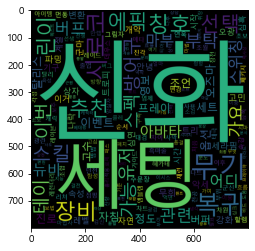

In [434]:
wc = WordCloud(font_path='malgun', width=400, height=400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(word_cnt)
plt.figure()
plt.imshow(gen);

In [435]:
wc.to_file('질문_키워드_워드클라우드.png')